In [3]:
def compute_mu(r, sigma, intensity, lambda_p, lambda_m, p):
    kappa_plus = (p * intensity) / (lambda_p - 1)
    kappa_minus = -1 * (1 - p) * intensity / (lambda_m + 1)
    kappa = kappa_plus + kappa_minus
    mu = r - 0.5 * sigma ** 2 - kappa
    return mu

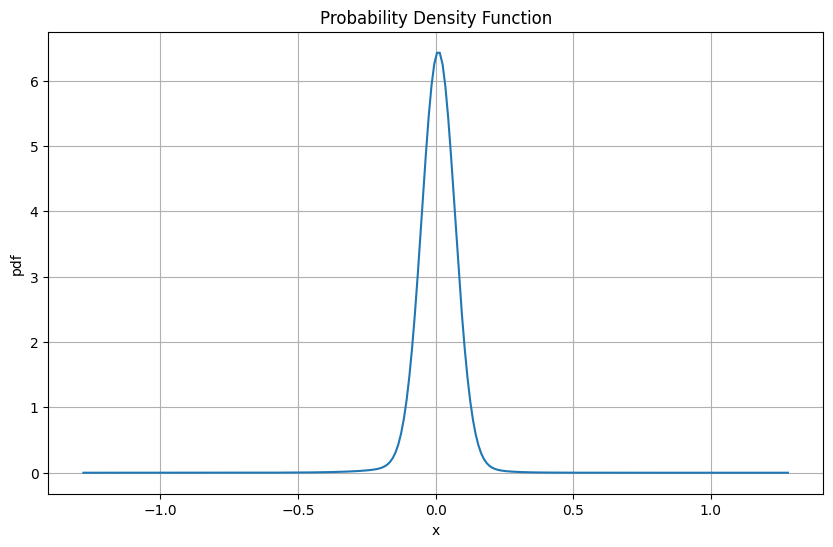

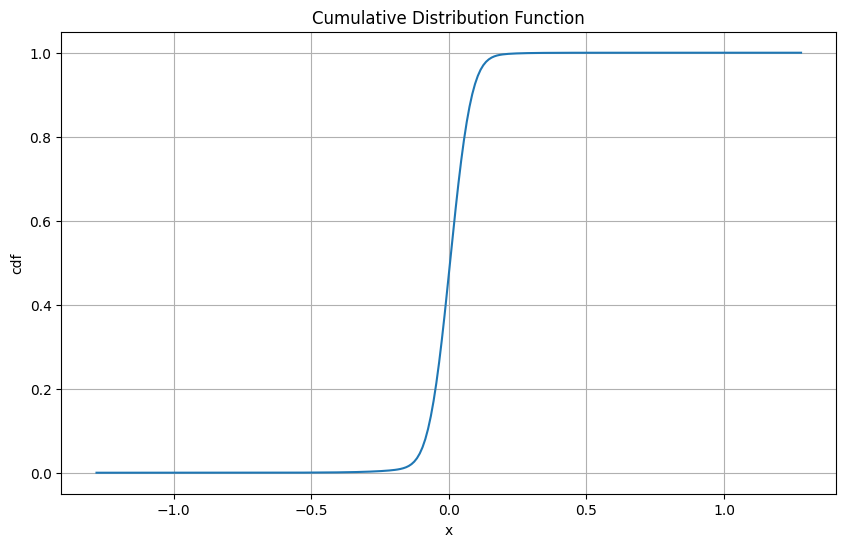

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import ifft, fftfreq
import cmath
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.optimizers as Optims

# Вспомогательные функции
def kou_chexp(xi, sigma, cp, cm, lm, lp, mu):
    sig2 = 0.5 * sigma ** 2
    temp1 = sig2 * xi ** 2 + (-mu * xi * 1j)
    temp2 = (cp * xi * 1j) / (xi * 1j + lp)
    temp3 = (cm * xi * 1j) / (xi * 1j + lm)
    return temp1 + temp2 + temp3

def kou_chf(xi, t, sigma, cp, cm, lm, lp, mu):
    temp1 = kou_chexp(xi, sigma, cp, cm, lm, lp, mu)
    return cmath.exp(-t * temp1)

# Параметры алгоритма
m = 8  # log_2(M), где M -- число точек пространства
d = 0.01  # Шаг пространства

#Параметры модели
cp, cm, intensity, lp, lm = 1, 1, 12, 10, -15
sigma, p, r = 0.3, 0.5, 0.05
mu = compute_mu(r, sigma, intensity, -lm, lp, p)
T = 10.0 / 252.0
M = 2 ** m  # Число точек пространства

xi = np.pi / d  # Текущее xi
dxi = -2 * xi / M  # Шаг в пространстве xi
x = M * d / 2.0  # Текущее x_k

chf = np.zeros(M, dtype=complex)
sign = 1
for l in range(M):
    phi = kou_chf(xi, T, sigma, cp, cm, lm, lp, mu)
    chf[l] = sign * phi
    xi += dxi
    sign *= -1

p = np.real(np.fft.ifft(chf))
odd_indices = np.arange(1, len(p), 2)
p[odd_indices] *= -1
p /= d

x = np.linspace(-M * d / 2, M * d / 2, M)

# Визуализация pdf
plt.figure(figsize=(10, 6))
plt.plot(x, p)
plt.xlabel('x')
plt.ylabel('pdf')
plt.title('Probability Density Function')
plt.grid(True)
plt.show()

# Построение cdf
cdf = np.zeros_like(p)
x = -(M // 2) * d
cdf[0] = sign * p[0] * d
for k in range(1, M):
    x += d
    cdf[k] = cdf[k-1] + sign * p[k] * d

# Визуализация cdf
x = np.linspace(-M * d / 2, M * d / 2, M)
plt.figure(figsize=(10, 6))
plt.plot(x, cdf)
plt.xlabel('x')
plt.ylabel('cdf')
plt.title('Cumulative Distribution Function')
plt.grid(True)
plt.show()

Для дальнейшей работы с cdf введём теперь следующую функцию:

$\tilde{F}_{X_T}(x)= \begin{cases}0, & x<x_0-1 \\ F_{X_T}\left(x_0\right)\left(x-x_0+1\right), & x_0-1 \leq x<x_0 \\ F_{X_T}\left(x_i\right)+\frac{F_{X_T}\left(x_{i+1}\right)-F_{X_T}\left(x_i\right)}{x_{i+1}-x_i}\left(x-x_i\right), & x_i \leq x<x_{i+1} \\ F_{X_T}\left(x_M\right)+\left(1-F_{X_T}\left(x_M\right)\right)\left(x-x_M\right), & x_M \leq x<x_M+1 \\ 1, & x \geq x_M+1\end{cases}$

Для неё выполняется следующее:
$\lvert\tilde{F}_{X_T}(x) - {F}_{X_T}(x)\rvert < \delta$, где $\delta$ определяется таким образом:

1) положим $\delta_{1}$ как максимум ${F}_{X_T}(x_i) - {F}_{X_T}(x_{i-1}), i = 0, ... , M$

2) положим $\delta_{2} = {F}_{X_T}(x_0)$ и $\delta_{3} = 1 - {F}_{X_T}(x_M)$

Тогда $\delta$ = max{$\delta_1, \delta_2, \delta_3$}

In [6]:
import numpy as np

def binary_search(x_values, x):
    """
    Находит индекс i такой, что x_values[i] <= x < x_values[i + 1].
    """
    left, right = 0, len(x_values) - 1

    while left <= right:
        mid = (left + right) // 2
        if x_values[mid] <= x < x_values[mid + 1]:
            return mid
        elif x < x_values[mid]:
            right = mid - 1
        else:
            left = mid + 1

    return None

def modify_cdf(x_values, F_values, x_modified):
    result = []
    """
    Вычисляет модифицированный CDF \tilde{F}_{X_T}(x) с использованием бинарного поиска.

    x_values: массив точек сетки [x_0, x_1, ..., x_M]
    F_values: массив значений F_{X_T}(x) на сетке
    x_modified: массив, для которого вычисляется \tilde{F}_{X_T}(x)
    """
    x_min, x_max = x_values[0], x_values[-1]
    F_min, F_max = F_values[0], F_values[-1]

    for x in x_modified:
        if x < x_min - 1:
            result.append(0)
        elif x_min - 1 <= x < x_min:
            result.append(F_min * (x - x_min + 1))
        elif x_max <= x < x_max + 1:
            result.append(F_max + (1 - F_max) * (x - x_max))
        elif x >= x_max + 1:
            result.append(1)
        else:
            index = binary_search(x_values, x)
            result.append(F_values[index] + (F_values[index + 1] - F_values[index]) * (x - x_values[index]) / (x_values[index + 1] - x_values[index]))
    return result

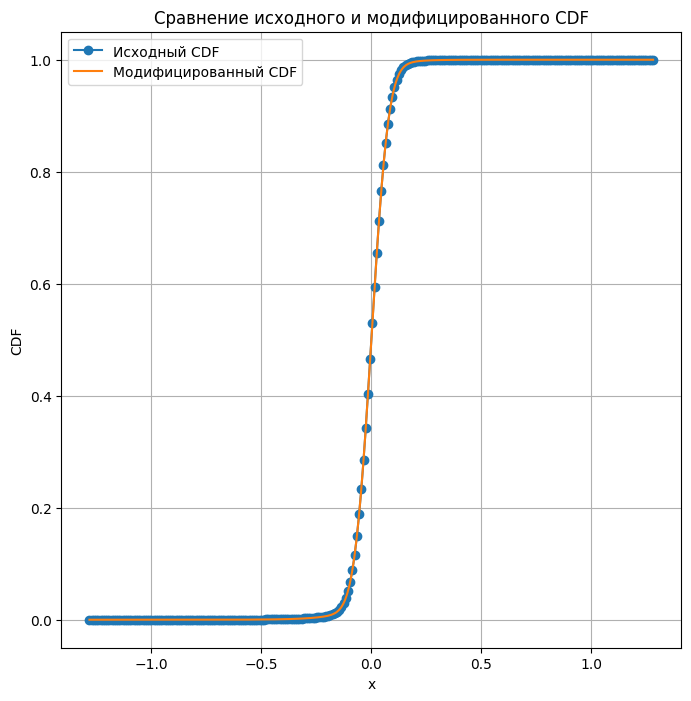

In [7]:
x_modified = np.linspace(-M * d / 2, M * d / 2, 2*M)
cdf_modified = modify_cdf(x, cdf, x_modified)
plt.figure(figsize=(8, 8))
plt.plot(x, cdf, label='Исходный CDF', marker='o', linestyle='-')
plt.plot(x_modified, cdf_modified, label='Модифицированный CDF', linestyle='-')
plt.title('Сравнение исходного и модифицированного CDF')
plt.xlabel('x')
plt.ylabel('CDF')
plt.legend()
plt.grid()
plt.show()


Теперь, согласно теореме Цыбенко, мы можем использовать полученные тренировочные данные для обучения нейронной сети с одним скрытым слоем следующего вида:

$$
G(x)=\sum_{j=1}^N \omega_j s\left(\alpha_j x+\beta_j\right), \quad \omega_j, \alpha_j, \beta_j \in \mathbb{R},
$$
причём $\alpha_j > 0, \omega_j > 0$.

Для построения воспользуемся библиотекой Keras.
Слои создаём при помощи класса Dense. Согласно документации, Dense имплементирует следующую операцию:

$ y = activation\left(x \cdot kernel + bias \right) $,
где
- $activation$ - функция активации (по умолчанию используется $linear$ - линейная функция следующего вида: $activation(x) = x$, то есть никак не изменяющая входное значение $x$).
- $kernel$ - матрица весов текущего слоя
- $bias$ - вектор смещения. Используется только в том случае, если параметр $use\_bias=True$, в противном случае состоит из нулей.

Таким образом, для скрытого слоя понадобится передать следующие параметры:
```
tf.keras.layers.Dense(
        20, # количество нейронов скрытого слоя
        input_shape=(1,), #на вход подаётся по одному значению
        activation='sigmoid', # activation(x) = s(x)
        kernel_constraint=tf.keras.constraints.NonNeg(), #ограничение на неотрицательность весов
        use_bias=True #использование вектора смещения
    )
```
После этого слоя значения будут иметь вид $activation(kernel \cdot x + bias) = s\left(\alpha_j x+\beta_j\right)$

Тогда выходной слой, согласно формуле, должен иметь следующие параметры:
```
tf.keras.layers.Dense(
        1, #выходной нейрон
        activation='linear', # activation(x) = x
        kernel_constraint=tf.keras.constraints.NonNeg(), #ограничения на неотрицательность весов
        use_bias=False #смещение для выходного слоя отсутствует
    )
```
Для данного слоя используется линейная функция активации, которая не изменяет значения, и, таким образом, выходные значения будут иметь вид:

 $activation(x' \cdot kernel' + bias' ) = kernel' \cdot x' + 0 = w_js\left(\alpha_j x+\beta_j\right)$, где
 - $x'$ - значения, полученные на скрытом слое: $x' = s\left(\alpha_j x+\beta_j\right)$
 - $bias' = 0$, так как параметр $use\_bias = False$


 Таким образом, комбинация этих двух слоёв позволяет получить необходимую для задачи структуру нейройнной сети.

Использование среднеквадратичной функции потерь

\begin{align}
 \text{Loss} = \frac{1}{N} \sum_{i=1}^n (\hat{y_i} - y_i)^2
\end{align}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1: loss = 0.559829831123352
Epoch 100: loss = 0.06778210401535034
Epoch 200: loss = 0.04336331784725189
Epoch 300: loss = 0.03320671245455742
Epoch 400: loss = 0.027218647301197052
Epoch 500: loss = 0.02300787717103958
Epoch 600: loss = 0.019741464406251907
Epoch 700: loss = 0.01711764745414257
Epoch 800: loss = 0.014937055297195911
Epoch 900: loss = 0.01316874846816063
Epoch 1000: loss = 0.01163630373775959
Epoch 1100: loss = 0.010273562744259834
Epoch 1200: loss = 0.009222254157066345
Epoch 1300: loss = 0.008349617011845112
Epoch 1400: loss = 0.0074026682414114475
Epoch 1500: loss = 0.006649308372288942
Epoch 1600: loss = 0.006063113920390606
Epoch 1700: loss = 0.005602963734418154
Epoch 1800: loss = 0.005261441692709923
Epoch 1900: loss = 0.004986572545021772
Epoch 2000: loss = 0.004721589386463165
Epoch 2100: loss = 0.004445037804543972
Epoch 2200: loss = 0.004148627165704966
Epoch 2300: loss = 0.003905234392732382
Epoch 2400: loss = 0.0036488797049969435
Epoch 2500: loss = 0

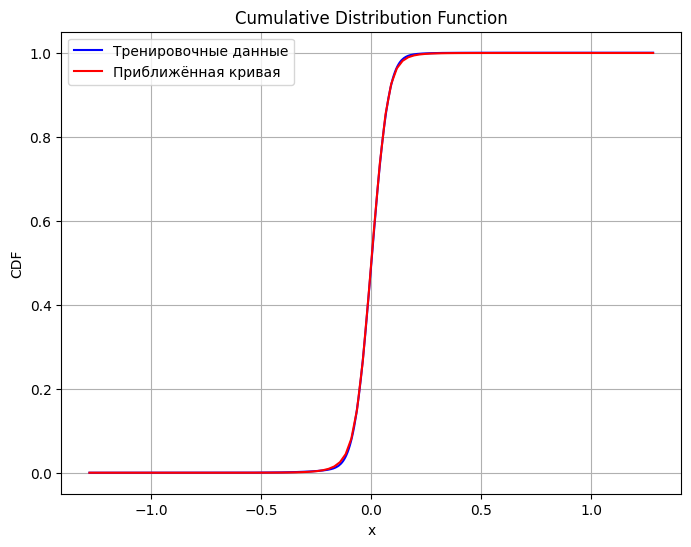

Веса первого слоя (W): [19.44375228881836, 35.450828552246094, 41.41624450683594, 31.712970733642578, 37.92026901245117, 36.7357063293457, 25.239351272583008, 31.69257164001465, 31.969764709472656, 13.148443222045898, 41.480770111083984, 35.31370162963867, 35.342529296875, 21.433530807495117, 41.042236328125, 28.04395866394043, 37.330997467041016, 37.10869216918945, 32.093082427978516, 27.94339370727539]
Смещения первого слоя (b): [0.19552400708198547, 0.7743678092956543, -1.9408562183380127, -0.1284976452589035, -1.1307536363601685, 1.2014234066009521, 0.08348345756530762, -0.1280883550643921, -0.1321730762720108, 0.38998210430145264, -1.9491161108016968, 0.716765284538269, 0.728980302810669, 0.15769481658935547, -1.8915742635726929, 0.00637968722730875, 1.1208540201187134, 1.281373381614685, -0.1327534317970276, 0.009728352539241314]
Веса второго слоя (V): [0.049633175134658813, 0.0500609390437603, 0.05017208680510521, 0.050046805292367935, 0.05011965334415436, 0.05007292330265045, 0

In [8]:
x_train = x_modified
y_train = np.array(cdf_modified)

# Callback для вывода текущей эпохи
class EpochLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % 100 == 0 or epoch == 0:
            print(f"Epoch {epoch + 1}: loss = {logs['loss']}")

model = tf.keras.Sequential([
        # Первый слой: f1(x) = s(a1*x + b1)
        tf.keras.layers.Dense(
        20,
        input_shape=(1,),
        activation='sigmoid',
        kernel_constraint=tf.keras.constraints.NonNeg(),
        use_bias=True
    ),

        # Второй слой: f2(x) = a2*s(a1*x + b1)
        tf.keras.layers.Dense(
        1,
        activation='linear',
        kernel_constraint=tf.keras.constraints.NonNeg(),
        kernel_regularizer=tf.keras.regularizers.L2(0.043),  # Регуляризация L2
        use_bias=False
    )
])


# Компиляция модели
model.compile(optimizer='adam', loss='mse')

# Обучение модели
history = model.fit(x_train, y_train, epochs=5000, verbose=0, callbacks = [EpochLogger()])

# Предсказания
x_test = np.linspace(x_train.min(), x_train.max(), 100).reshape(-1, 1)
y_pred = model.predict(x_test)

# Визуализация результатов
plt.figure(figsize=(8, 6))
plt.plot(x_train, y_train, label='Тренировочные данные', color='blue')
plt.plot(x_test, y_pred, label='Приближённая кривая', color='red')
plt.title('Cumulative Distribution Function')
plt.xlabel('x')
plt.ylabel('CDF')
plt.legend()
plt.grid(True)
plt.show()

# Веса и смещения первого слоя
weights, biases = model.layers[0].get_weights()
W = weights.T.flatten().tolist()
b = biases.tolist()

print("Веса первого слоя (W):", W)
print("Смещения первого слоя (b):", b)

# Веса второго слоя
weights = model.layers[1].get_weights()[0]  # Получаем только веса второго слоя
V = weights.T.flatten().tolist()

print("Веса второго слоя (V):", V)

Использование в качестве функции потерь сумму расстояний Кульбака от первого до второго распределения и от второго до первого:

\begin{align}
\text{Loss} = \frac{1}{N} \sum_{i=1}^{N} \ln \frac{\hat{y}}{y} (\hat{y_i} - y_i)
\end{align}


Epoch 1: loss = 4.641292572021484
Epoch 100: loss = 0.06688611954450607
Epoch 200: loss = 0.044789936393499374
Epoch 300: loss = 0.033326271921396255
Epoch 400: loss = 0.025306496769189835
Epoch 500: loss = 0.021379822865128517
Epoch 600: loss = 0.013539805077016354
Epoch 700: loss = 0.009340436197817326
Epoch 800: loss = 0.007174737751483917
Epoch 900: loss = 0.005813726224005222
Epoch 1000: loss = 0.0047174058854579926
Epoch 1100: loss = 0.004105128813534975
Epoch 1200: loss = 0.0040475837886333466
Epoch 1300: loss = 0.004038432613015175
Epoch 1400: loss = 0.004003115929663181
Epoch 1500: loss = 0.004051092080771923
Epoch 1600: loss = 0.004020212218165398
Epoch 1700: loss = 0.00404391810297966
Epoch 1800: loss = 0.004113820847123861
Epoch 1900: loss = 0.003994753118604422
Epoch 2000: loss = 0.0040177032351493835
Epoch 2100: loss = 0.003992309793829918
Epoch 2200: loss = 0.004010857082903385
Epoch 2300: loss = 0.00401171064004302
Epoch 2400: loss = 0.0039910790510475636
Epoch 2500: lo

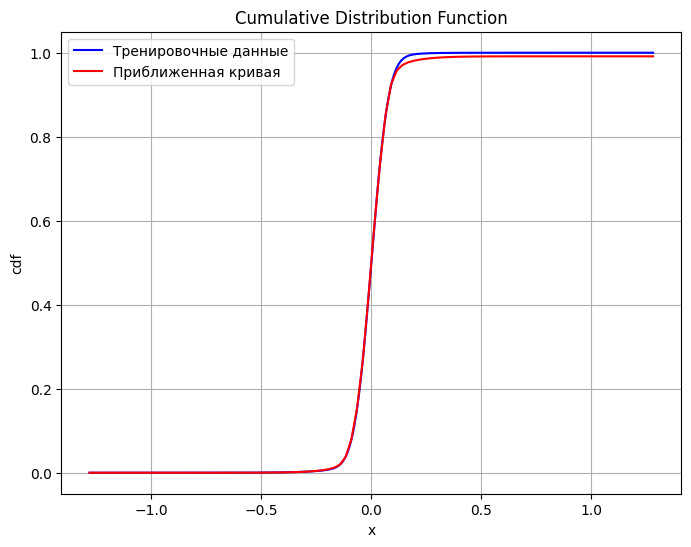

Веса первого слоя (W): [50.349693298339844, 44.70419692993164, 45.02140808105469, 45.153507232666016, 52.07888412475586, 51.189022064208984, 11.655722618103027, 45.169254302978516, 51.6320686340332, 45.20155334472656]
Смещения первого слоя (b): [-2.5824646949768066, 0.3521215319633484, 0.676210880279541, -0.7249664664268494, -3.1354222297668457, 4.208232879638672, -0.1453191488981247, -0.7328647971153259, 2.0589470863342285, 0.8312303423881531]
Веса второго слоя (V): [0.09935549646615982, 0.0996139720082283, 0.09971361607313156, 0.0993778258562088, 0.09939638525247574, 0.10008874535560608, 0.0945780947804451, 0.09937674552202225, 0.10013477504253387, 0.09976387023925781]


In [9]:
x_train = x_modified
y_train = np.array(cdf_modified)

# Callback для вывода текущей эпохи
class EpochLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % 100 == 0 or epoch == 0:
            print(f"Epoch {epoch + 1}: loss = {logs['loss']}")

def kullback(y_true, y_pred):
    epsilon = 1e-10
    y_true = K.clip(y_true, epsilon, 1)
    y_pred = K.clip(y_pred, epsilon, 1)
    return K.mean(K.log(y_true / y_pred) * (y_true - y_pred))

# Создание модели нейронной сети
model = tf.keras.Sequential([
    # Первый слой: f1(x) = s(a1*x + b1)
    tf.keras.layers.Dense(
        10,
        input_shape=(1,),
        activation='sigmoid',
        kernel_constraint=tf.keras.constraints.NonNeg(),
        use_bias=True
    ),

    # Второй слой: f2(x) = a2*s(a1*x + b1)
    tf.keras.layers.Dense(
        1,
        activation='linear',
        kernel_constraint=tf.keras.constraints.NonNeg(),
        kernel_regularizer=tf.keras.regularizers.L2(0.04),  # Регуляризация L2
        use_bias=False
    )
])

# Компиляция модели
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss=kullback)

# Обучение
history = model.fit(x_train, y_train, epochs=2500, verbose=0, callbacks=[EpochLogger()])

# Данные для визуализации
x_test = np.linspace(x_train.min(), x_train.max(), 100).reshape(-1, 1)
y_pred = model.predict(x_test)

# Визуализация полученных результатов
plt.figure(figsize=(8, 6))
plt.plot(x_train, y_train, color='blue', label='Тренировочные данные')
plt.plot(x_test, y_pred, color='red', label='Приближенная кривая')
plt.title('Cumulative Distribution Function')
plt.xlabel('x')
plt.ylabel('cdf')
plt.legend()
plt.grid(True)
plt.show()

# Веса и смещения первого слоя
weights, biases = model.layers[0].get_weights()
W = weights.T.flatten().tolist()
b = biases.tolist()

print("Веса первого слоя (W):", W)
print("Смещения первого слоя (b):", b)

# Веса второго слоя
weights = model.layers[1].get_weights()[0]  # Получаем только веса второго слоя
V = weights.T.flatten().tolist()

print("Веса второго слоя (V):", V)

Далее для реализации алгоритма понадобится смоделировать логистическое распределение, cdf которого является

$\sigma = \frac{1}{1 + e^{-x}}$

Случайная величина Y cо стандартным логистическим распределением может быть смоделирована при помощи обратной функции

$\sigma^{-1}(u) = \ln{\frac{1}{1 - u}}$, где $u \in U(0, 1)$ - равномерное
распределение на интервале $(0, 1)$

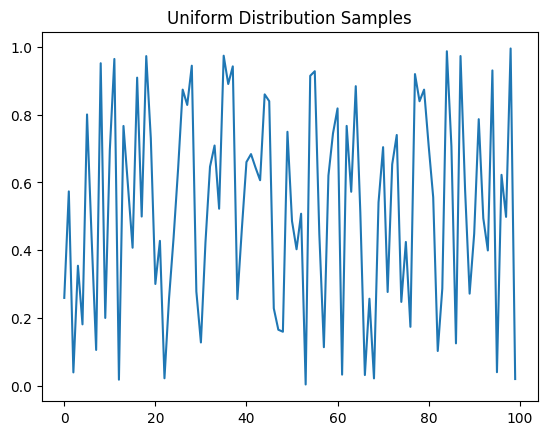

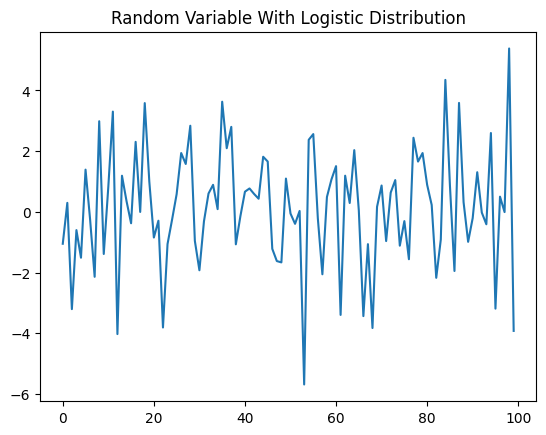

In [10]:
def sigma(x):
    return 1 / (1 + exp(-x))

def inverse_logistic(u):
    return np.log(u/(1-u))

U = np.random.uniform(0, 1, 100)
plt.plot(U)
plt.title("Uniform Distribution Samples")
plt.show()

Y = inverse_logistic(U)
plt.plot(Y)
plt.title("Random Variable With Logistic Distribution")
plt.show()

Таким образом, имеем случайную величину Z следующего вида

$Z =
\begin{cases}
\frac{Y_1}{\alpha_1} -\frac{\beta_1}{\alpha_1}, & \text {с вероятностью } p_1 \\
\cdots \\
\frac{Y_j}{\alpha_j} -\frac{\beta_j}{\alpha_j}, & \text {с вероятностью } p_j \\
\cdots \\
\frac{Y_N}{\alpha_N} -\frac{\beta_N}{\alpha_N} & \text {с вероятностью } p_N ,
\end{cases}$

где $Y_j \stackrel{d}{\sim} Y$ независимы, $p_j>0, \alpha_j>0, \beta_j \in \mathbb{R}$, такие что
$$
\begin{gathered}
\sum_{j=1}^N p_j=1 \\
\left|F_X(x)-F_Z(x)\right|<\epsilon, \text { для всех } x \in \mathbb{R}
\end{gathered}
$$
$F_X(x)$ и $F_Z(x)$ - cdf $X$ и $Z$ соответственно.

В качестве $\alpha_i$ выступают веса первого слоя, $p_i$ - веса второго слоя, а $\beta_i$ - смещения первого слоя.


Теперь положим, что цена опциона описывается следующей формулой:
\begin{align}
V(x, T) = e^{-rT}E[H(x+X_T)],
\end{align}

где $H(x)$ - функция выплат.

Определив достаточно большое число симуляций $L$, можно аппроксимировать V(x, T) с дисконтированным средним для $H(x + z_i)$ следующим образом:

\begin{align}
V(x, T) = e^{-rT}\frac{1}{L}\sum_{i}^{N}H(x+z_i),
\end{align}

где $z_i, i = 1, ...,L$  - выборочные значения из
 $\frac{Y}{\alpha_i} - \frac{\beta_i}{\alpha_i}$ с вероятностями $p_j, j = 1,...,N$



```
# Выбран кодовый формат
```

Оценим колл-опцион с функцией выплаты $H(x) = max(x - K, 0)$   со следующими параметрами:

$S_0 = 100$ - начальная цена актива, $K = 80$ - cтрайк-цена, $r = 0.05$ - безрисковая ставка,
$T = 1$ - время до истечения (1 год),
$L = 10000$  - общее число симуляций

In [31]:
import numpy as np
S_0 = 100
K = 80
T = 10/252
L = 10000

alphas = [19.44375228881836, 35.450828552246094, 41.41624450683594, 31.712970733642578, 37.92026901245117, 36.7357063293457, 25.239351272583008, 31.69257164001465, 31.969764709472656, 13.148443222045898, 41.480770111083984, 35.31370162963867, 35.342529296875, 21.433530807495117, 41.042236328125, 28.04395866394043, 37.330997467041016, 37.10869216918945, 32.093082427978516, 27.94339370727539]
betas = [0.19552400708198547, 0.7743678092956543, -1.9408562183380127, -0.1284976452589035, -1.1307536363601685, 1.2014234066009521, 0.08348345756530762, -0.1280883550643921, -0.1321730762720108, 0.38998210430145264, -1.9491161108016968, 0.716765284538269, 0.728980302810669, 0.15769481658935547, -1.8915742635726929, 0.00637968722730875, 1.1208540201187134, 1.281373381614685, -0.1327534317970276, 0.009728352539241314]
probabilities = [0.049633175134658813, 0.0500609390437603, 0.05017208680510521, 0.050046805292367935, 0.05011965334415436, 0.05007292330265045, 0.04992753639817238, 0.05004660785198212, 0.05004918575286865, 0.048847608268260956, 0.050172895193099976, 0.050060007721185684, 0.05006019398570061, 0.04976527765393257, 0.05016738548874855, 0.049995940178632736, 0.05007355287671089, 0.05007653310894966, 0.05005025863647461, 0.04999403655529022]


def payoff(s):
    return max(s - K, 0)

def inverse_logistic(u):
    return np.log(u/(1-u))

j = 0
i = 0
m = 0
V = 0
total = 0
N = len(probabilities)

while j <= N:
    m += int(probabilities[j - 1] * L)
    while i <= m:
        # генерация y_i
        u = np.random.uniform(0, 1)
        y_i = inverse_logistic(u)
        # расчёт z_i и вычисление S_T
        z_i = (y_i - betas[j - 1])/alphas[j - 1]
        S_T = S_0 * np.exp(z_i)
        V += payoff(S_T)
        i += 1
    j += 1

V = np.exp(-r * T) * V / L
print(f"Стоимость опциона: {V:.2f}")

Стоимость опциона: 21.03


Теперь посчитаем функцию распределения процесса супремума и инфимума модели Коу и построим нейросеть для их аппроксимации.
Процессы супремума и инфимума задаются соответственно следующим образом:
$$
\bar{X}_t=\sup _{0 \leq s \leq t} X_s \quad \underline{X}_t=\inf _{0 \leq s \leq t} X_s
$$
Функции распределения для них имеют следующий вид:
$$F_{+}(x, q)=\mathbf{P}\left(\bar{X}_T<x\right) \quad F_{-}(x, q)=\mathbf{P}\left(\underline{X}_T<x\right)$$

Применяя преобразование Лапласа к $F_+$ и $F_-$ получаем следующее:
$\hat{F}_{+}(-x, q)=\frac{\tau}{k \ln 2}\left(\alpha_0+\alpha_1-\alpha_0 \exp ^{\beta_0^{+} x}-\alpha_1 \exp ^{\beta_1^{+} x}\right)$
$\hat{F}_{-}(-x, q)=\frac{\tau}{k \ln 2}\left(\alpha_0 \exp ^{\beta_0^{-} x}+\alpha_1 \exp ^{\beta_1^{-} x}\right)$

где $\beta_0^+, \beta_0^-, \beta_1^+, \beta_1^-$ - корни уравнения $\Psi(\xi)+q=0$,
$$
\left\{\begin{array}{l}\alpha_0=\frac{\beta_1^{+}\left(\beta_0^{+}+\lambda_{-}\right)}{\lambda_{-}\left(\beta_1^{+}-\beta_0^{+}\right)} \\ \alpha_1=1-\frac{\beta_1^{+}\left(\beta_0^{+}+\lambda_{-}\right)}{\lambda_{-}\left(\beta_1^{+}-\beta_0^{+}\right)}\end{array}\right.
$$ - коэффициенты для $\hat{F}_{+}(-x, q)$ и
$$
\left\{\begin{array}{l}\alpha_0=\frac{\beta_1^{-}\left(\beta_0^{-}+\lambda_{+}\right)}{\lambda_{+}\left(\beta_1^{-}-\beta_0^{-}\right)} \\ \alpha_1=1-\frac{\beta_1^{-}\left(\beta_0^{-}+\lambda_{+}\right)}{\lambda_{+}\left(\beta_1^{-}-\beta_0^{-}\right)}\end{array}\right.
$$ - коэффициенты для $\hat{F}_{-}(-x, q)$

Применив обратное преобразование Лапласа получаем итоговые формулы для кумулятивных функций распределения:
$$
f_{+}(-x, q)=\frac{1}{\tau} \sum_{k=1}^{14} W_k \frac{\tau}{k \ln 2}\left(\alpha_0+\alpha_1-\alpha_0 \exp ^{\beta_0^{+} x}-\alpha_1 \exp ^{\beta_1^{+} x}\right)
$$

$$
f_{-}(-x, q)=\frac{1}{\tau} \sum_{k=1}^{14} W_k \frac{\tau}{k \ln 2}\left(\alpha_0 \exp ^{\beta_0^{-} x}+\alpha_1 \exp ^{\beta_1^{-} x}\right)
$$


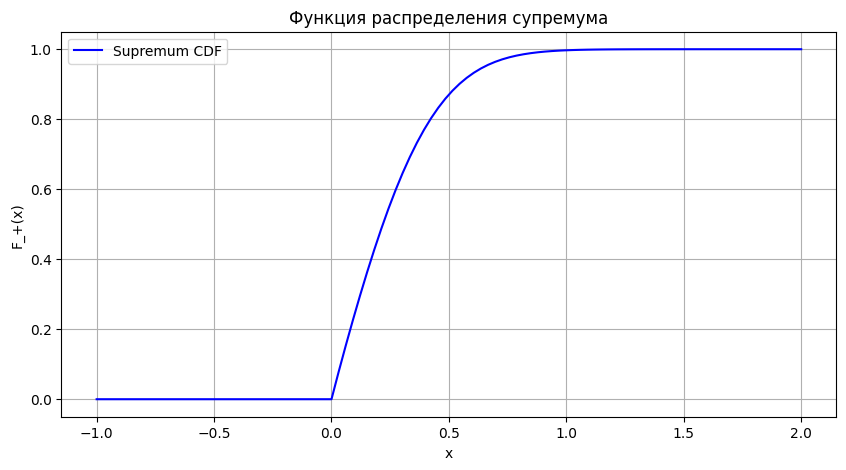

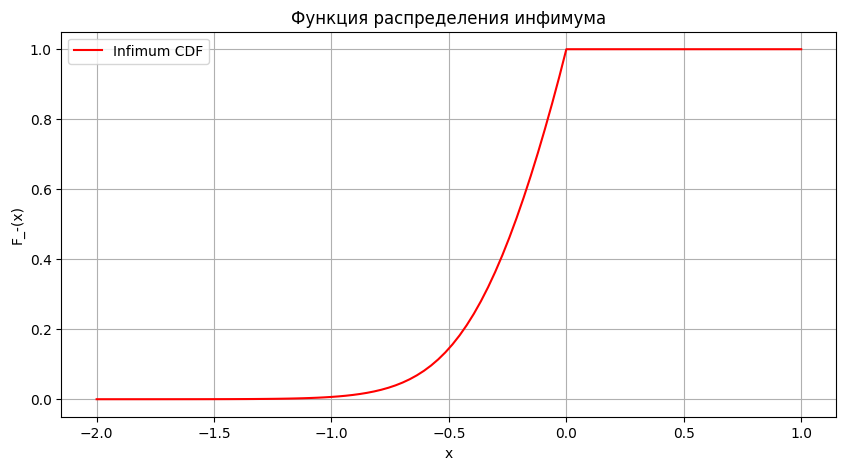

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

Wk = [0.001925409, -4.438067364, 640.5026522, -23981.45609,
      374522.0548, -3048701.383, 14616804.79, -44323236.19,
      88443902.51, -117930112.2, 104199059.9, -58634818.24,
      19046911.5, -2720987.357]

def find_roots(sigma, l_, l, mu, c, c_, q):
    a = -(sigma**2)
    b = -l*(sigma**2) - l_*(sigma**2) - 2*mu
    cc = ((-l*sigma**2 - 2*mu) * l_ - 2*mu*l + 2*q + 2*c + 2*c_)
    d = ((-2*mu*l + 2*q + 2*c) * l_ + 2*l * (q + c_))
    ee = 2*q*l_*l

    coeffs = [a, b, cc, d, ee]
    roots = np.roots(coeffs)

    b1_, b0_, b0, b1 = None, None, None, None

    for root in roots:
        if root.real < -l and b1_ is None:
            b1_ = root.real
        elif -l < root.real < 0 and b0_ is None:
            b0_ = root.real
        elif 0 < root.real < -l_ and b0 is None:
            b0 = root.real
        elif -l_ < root.real and b1 is None:
            b1 = root.real

    return b1_, b0_, b0, b1

def sup_cdf(x, sigma, r, t, c, c_, l, l_):
    mu = r - (sigma**2 / 2) + c / (l + 1) + c_ / (l_ + 1)
    t_f = 0

    if x <= 0:
        return 0
    else:
        for k in range(14):
            q = ((k + 1) * np.log(2)) / t
            b1_, b0_, b0, b1 = find_roots(sigma, l_, l, mu, c, c_, q)
            alpha_0 = (b1 * (b0 + l_)) / (l_ * (b1 - b0))
            alpha_1 = 1 - alpha_0
            t_f += Wk[k] * ((1 / q) * (alpha_0 + alpha_1 - alpha_1 * np.exp(b1 * (-x))
                                       - alpha_0 * np.exp(b0 * (-x))))
        return t_f / t

def inf_cdf(x, sigma, r, t, l, l_, c_, c):
    mu = r - (sigma**2 / 2) + c / (l + 1) + c_ / (l_ + 1)
    t_f_ = 0

    if x >= 0:
        return 1
    else:
        for k in range(14):
            q = ((k + 1) * np.log(2)) / t
            b1_, b0_, b0, b1 = find_roots(sigma, l_, l, mu, c, c_, q)
            alpha_0 = (b1_ * (b0_ + l)) / (l * (b1_ - b0_))
            alpha_1 = 1 - alpha_0
            t_f_ += Wk[k] * ((1 / q) * (alpha_1 * np.exp(b1_ * (-x))
                                       + alpha_0 * np.exp(b0_ * (-x))))
        return t_f_ / t


sigma = 0.3
r = 0.05
t = 1.0
c = 1
c_ = 1
l = 10
l_ = -15

x_vals = np.linspace(-1, 2, 100)
x_vals1 = np.linspace(-2, 1, 100)

sup_cdf_vals = [sup_cdf(x, sigma, r, t, c, c_, l, l_) for x in x_vals]
inf_cdf_vals = [inf_cdf(x, sigma, r, t, l, l_, c_, c) for x in x_vals1]

plt.figure(figsize=(10, 5))
plt.plot(x_vals, sup_cdf_vals, label="Supremum CDF", color="blue")
plt.xlabel("x")
plt.ylabel("F_+(x)")
plt.title("Функция распределения супремума")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(x_vals1, inf_cdf_vals, label="Infimum CDF", color="red")
plt.xlabel("x")
plt.ylabel("F_-(x)")
plt.title("Функция распределения инфимума")
plt.legend()
plt.grid()
plt.show()


Теперь, аппроксимируем полученные функции

Epoch 1: loss = 1.8955734968185425
Epoch 100: loss = 0.0346563421189785
Epoch 200: loss = 0.019677860662341118
Epoch 300: loss = 0.01302952878177166
Epoch 400: loss = 0.009505596943199635
Epoch 500: loss = 0.006941833067685366
Epoch 600: loss = 0.005344714503735304
Epoch 700: loss = 0.004312950652092695
Epoch 800: loss = 0.0036585202906280756
Epoch 900: loss = 0.0031126062385737896
Epoch 1000: loss = 0.0028157243505120277
Epoch 1100: loss = 0.002525611314922571
Epoch 1200: loss = 0.0022697621025145054
Epoch 1300: loss = 0.0020054192282259464
Epoch 1400: loss = 0.0018809938337653875
Epoch 1500: loss = 0.001721251173876226
Epoch 1600: loss = 0.0015504627954214811
Epoch 1700: loss = 0.0014439327642321587
Epoch 1800: loss = 0.0012924300972372293
Epoch 1900: loss = 0.0012173582799732685
Epoch 2000: loss = 0.0011418432695791125
Epoch 2100: loss = 0.0010647597955539823
Epoch 2200: loss = 0.0010032503632828593
Epoch 2300: loss = 0.000980309327133
Epoch 2400: loss = 0.0009316331706941128
Epoch 

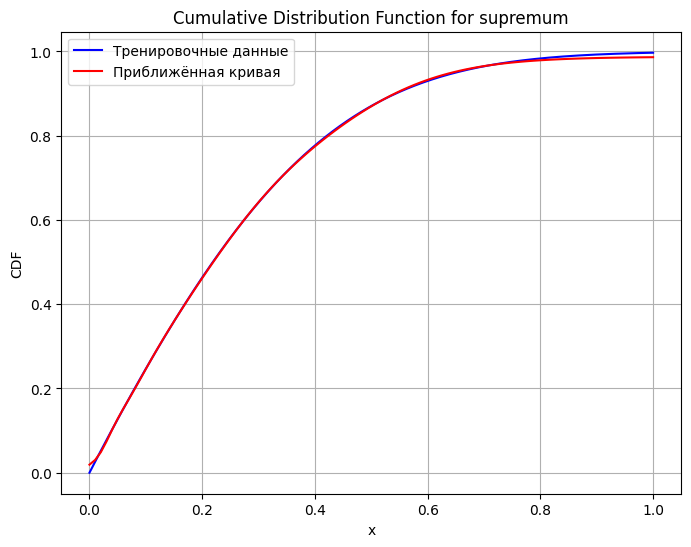

Веса первого слоя (W): [32.689056396484375, 17.78884506225586, 73.86536407470703, 12.289310455322266, 54.752891540527344, 22.988500595092773, 10.157346725463867, 20.995351791381836, 25.56454849243164, 85.96771240234375, 37.99492645263672, 10.500428199768066, 12.458085060119629, 22.974102020263672, 17.12242317199707, 10.141288757324219, 10.1848783493042, 44.56059646606445, 10.159975051879883, 29.400774002075195, 24.315013885498047, 10.141637802124023, 85.95683288574219, 32.28564453125, 10.59212589263916, 11.799318313598633, 10.165544509887695, 18.146516799926758, 40.91920471191406, 15.650116920471191, 16.210302352905273, 38.54713439941406, 30.191097259521484, 10.180706977844238, 10.147117614746094, 85.97576904296875, 20.68228530883789, 12.515161514282227, 17.179479598999023, 16.756803512573242, 20.466064453125, 44.66470718383789, 41.87833023071289, 16.271427154541016, 10.156052589416504, 79.86664581298828, 10.174814224243164, 10.149624824523926, 10.774896621704102, 20.907487869262695]
С

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import ifft, fftfreq
import cmath
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.optimizers as Optims

x_train = np.concatenate([
    np.linspace(0, 0.1, 500),
    np.linspace(0.1, 1, 500)
])
y_train = np.array([sup_cdf(x, sigma, r, t, c, c_, l, l_) for x in x_train])

# Callback для вывода текущей эпохи
class EpochLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % 100 == 0 or epoch == 0:
            print(f"Epoch {epoch + 1}: loss = {logs['loss']}")

model = tf.keras.Sequential([
        # Первый слой: f1(x) = s(a1*x + b1)
        tf.keras.layers.Dense(
        50,
        input_shape=(1,),
        activation='sigmoid',
        kernel_constraint=tf.keras.constraints.NonNeg(),
        use_bias=True
    ),

        # Второй слой: f2(x) = a2*s(a1*x + b1)
        tf.keras.layers.Dense(
        1,
        activation='linear',
        kernel_constraint=tf.keras.constraints.NonNeg(),
        kernel_regularizer=tf.keras.regularizers.L2(0.043),  # Регуляризация L2
        use_bias=False
    )
])


# Компиляция модели
model.compile(optimizer=Optims.Adam(learning_rate=0.001), loss='mse')

# Обучение модели
history = model.fit(x_train, y_train, epochs=5000, verbose=0,  callbacks = [EpochLogger()])

# Предсказания
x_test = np.linspace(x_train.min(), x_train.max(), 100).reshape(-1, 1)
y_pred = model.predict(x_test)

# Визуализация результатов
plt.figure(figsize=(8, 6))
plt.plot(x_train, y_train, label='Тренировочные данные', color='blue')
plt.plot(x_test, y_pred, label='Приближённая кривая', color='red')
plt.title('Cumulative Distribution Function for supremum')
plt.xlabel('x')
plt.ylabel('CDF')
plt.legend()
plt.grid(True)
plt.show()

# Веса и смещения первого слоя
weights, biases = model.layers[0].get_weights()
W = weights.T.flatten().tolist()
b = biases.tolist()

print("Веса первого слоя (W):", W)
print("Смещения первого слоя (b):", b)

# Веса второго слоя
weights = model.layers[1].get_weights()[0]  # Получаем только веса второго слоя
V = weights.T.flatten().tolist()

print("Веса второго слоя (V):", V)
print("Сумма весов второго слоя (V): ", sum(V))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1: loss = 1.2128968238830566
Epoch 100: loss = 0.028008265420794487
Epoch 200: loss = 0.012737324461340904
Epoch 300: loss = 0.008000815287232399
Epoch 400: loss = 0.0049096387811005116
Epoch 500: loss = 0.0029527582228183746
Epoch 600: loss = 0.0019352160161361098
Epoch 700: loss = 0.0015541294123977423
Epoch 800: loss = 0.001391398604027927
Epoch 900: loss = 0.0013046386884525418
Epoch 1000: loss = 0.0012143882922828197
Epoch 1100: loss = 0.0011592947412282228
Epoch 1200: loss = 0.0011208769865334034
Epoch 1300: loss = 0.0010818769223988056
Epoch 1400: loss = 0.0010654623620212078
Epoch 1500: loss = 0.0010546912671998143
Epoch 1600: loss = 0.0010206756414845586
Epoch 1700: loss = 0.0010131588205695152
Epoch 1800: loss = 0.0009951144456863403
Epoch 1900: loss = 0.000977370305918157
Epoch 2000: loss = 0.000971123285125941
Epoch 2100: loss = 0.0009719347581267357
Epoch 2200: loss = 0.0009612861322239041
Epoch 2300: loss = 0.0009539155871607363
Epoch 2400: loss = 0.0009485387126915

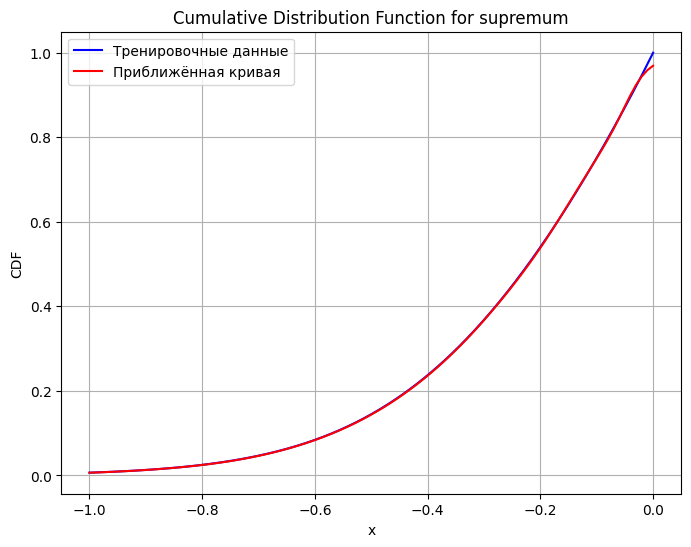

Веса первого слоя (W): [24.961917877197266, 18.698867797851562, 12.579691886901855, 17.35465431213379, 12.841082572937012, 22.766761779785156, 22.676849365234375, 17.177814483642578, 58.47888946533203, 41.36792755126953, 22.53152847290039, 13.330246925354004, 27.847681045532227, 58.136295318603516, 19.49524688720703, 41.233707427978516, 22.208263397216797, 39.54383850097656, 18.172632217407227, 15.436392784118652, 16.348398208618164, 25.069725036621094, 17.495040893554688, 30.354297637939453, 12.296514511108398, 24.212661743164062, 15.760966300964355, 12.884124755859375, 30.5128116607666, 12.873692512512207, 30.748291015625, 9.938371658325195, 16.6785945892334, 14.864971160888672, 10.993876457214355, 56.086639404296875, 10.041915893554688, 13.929659843444824, 40.67732238769531, 28.70743751525879, 16.690391540527344, 21.14449691772461, 10.44314193725586, 9.74700927734375, 11.748872756958008, 12.638128280639648, 57.33346939086914, 57.00996398925781, 7.999402046203613, 24.559551239013672]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import ifft, fftfreq
import cmath
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.optimizers as Optims

x_train = np.concatenate([
    np.linspace(-1, -0.1, 500),
    np.linspace(-0.1, 0, 500)
])
y_train = np.array([inf_cdf(x, sigma, r, t, l, l_, c_, c) for x in x_train])

# Callback для вывода текущей эпохи
class EpochLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % 100 == 0 or epoch == 0:
            print(f"Epoch {epoch + 1}: loss = {logs['loss']}")

model = tf.keras.Sequential([
        # Первый слой: f1(x) = s(a1*x + b1)
        tf.keras.layers.Dense(
        50,
        input_shape=(1,),
        activation='sigmoid',
        kernel_constraint=tf.keras.constraints.NonNeg(),
        use_bias=True
    ),

        # Второй слой: f2(x) = a2*s(a1*x + b1)
        tf.keras.layers.Dense(
        1,
        activation='linear',
        kernel_constraint=tf.keras.constraints.NonNeg(),
        kernel_regularizer=tf.keras.regularizers.L2(0.043),  # Регуляризация L2
        use_bias=False
    )
])


# Компиляция модели
model.compile(optimizer=Optims.Adam(learning_rate=0.001), loss='mse')

# Обучение модели
history = model.fit(x_train, y_train, epochs=5000, verbose=0, callbacks = [EpochLogger()])

# Предсказания
x_test = np.linspace(x_train.min(), x_train.max(), 100).reshape(-1, 1)
y_pred = model.predict(x_test)

# Визуализация результатов
plt.figure(figsize=(8, 6))
plt.plot(x_train, y_train, label='Тренировочные данные', color='blue')
plt.plot(x_test, y_pred, label='Приближённая кривая', color='red')
plt.title('Cumulative Distribution Function for supremum')
plt.xlabel('x')
plt.ylabel('CDF')
plt.legend()
plt.grid(True)
plt.show()

# Веса и смещения первого слоя
weights, biases = model.layers[0].get_weights()
W = weights.T.flatten().tolist()
b = biases.tolist()

print("Веса первого слоя (W):", W)
print("Смещения первого слоя (b):", b)

# Веса второго слоя
weights = model.layers[1].get_weights()[0]  # Получаем только веса второго слоя
V = weights.T.flatten().tolist()

print("Веса второго слоя (V):", V)
print("Сумма весов второго слоя (V): ", sum(V))